# Fit AdapIF to HH Spike Trains

In [1]:
from brian2 import *
from brian2modelfitting import *

import numpy as np

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [2]:
dt = 0.01*ms
defaultclock.dt = dt

## Load the Data

In [3]:
voltage1 = genfromtxt('voltage1nA.csv', delimiter=',')
voltage2 = genfromtxt('voltage2nA.csv', delimiter=',')

In [4]:
inp_cur1 = genfromtxt('inp_cur1nA.csv', delimiter=',')
inp_cur2 = genfromtxt('inp_cur2nA.csv', delimiter=',')
inp_current = [inp_cur1, inp_cur2]
inp_current

[array([ 0.        , -0.01416314,  0.06263459, ..., -0.44478035,
        -0.39163954, -0.33014548]),
 array([ 0.        ,  0.39594954,  0.27878635, ..., -0.55344109,
        -0.71057181, -0.62256885])]

In [5]:
out_spikes1 = genfromtxt('out_spikes1nA.csv', delimiter=',')
out_spikes2 = genfromtxt('out_spikes2nA.csv', delimiter=',')
out_spikes = [out_spikes1, out_spikes2]
# out_spikes

## Model Fitting

In [6]:
# tau = 12.44*ms
# taut = 97.64*ms
# a = 0.21
# alpha = 7.2*mV
# R = 76*Mohm

model = '''
        dv/dt = (R*I- v)/tau : 1
        dvt/dt = (a*v - vt) / taut :1
        alpha : 1 (constant)
        a : 1 (constant)
        R : 1/amp (constant)
        tau : second (constant)
        taut : second (constant)
        D: second(constant)
        '''

reset = '''
v = 0
vt = vt + alpha
'''

In [7]:
set_device('cpp_standalone', directory='parallel2', clean=False)

In [8]:
n_opt = NevergradOptimizer('DE')
metric = GammaFactor(time=50*second, delta=4*ms)

In [9]:
fitter = SpikeFitter(model=model, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=500,
                     threshold='v > 1 + vt',
                     reset=reset,
                     refractory='D',
                     )

exponential_euler


In [10]:
result_dict, error = fitter.fit(n_rounds=10,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                alpha=[0.1, 2.2],
                                a = [0.01, 0.1],
                                R = [1, 15] * 1/nA, 
                                tau = [7, 20]*ms,
                                taut = [30, 100]*ms,
                                D = [1, 2]*ms
                               )

Round 0: fit (0.07480160240351776, 0.7457273057946336, 0.08382491684073405, 0.0013771542668615893, 0.014097009089252228, 11866471116.533703) with error: 0.012713773158505914
Round 1: fit (0.07480160240351776, 0.7457273057946336, 0.08382491684073405, 0.0013771542668615893, 0.014097009089252228, 11866471116.533703) with error: 0.012713773158505914
Round 2: fit (0.07480160240351776, 0.7457273057946336, 0.08382491684073405, 0.0013771542668615893, 0.014097009089252228, 11866471116.533703) with error: 0.012713773158505914
Round 3: fit (0.07480160240351776, 0.7457273057946336, 0.08382491684073405, 0.0013771542668615893, 0.014097009089252228, 11866471116.533703) with error: 0.012713773158505914
Round 4: fit (0.07480160240351776, 0.7457273057946336, 0.08382491684073405, 0.0013771542668615893, 0.014097009089252228, 11866471116.533703) with error: 0.012713773158505914
Round 5: fit (0.07480160240351776, 0.7457273057946336, 0.08382491684073405, 0.0013771542668615893, 0.014097009089252228, 118664711

In [11]:
result_dict

{'a': 0.07480160240351776,
 'alpha': 0.7457273057946336,
 'taut': 0.08382491684073405,
 'D': 0.0013771542668615893,
 'tau': 0.014097009089252228,
 'R': 11866471116.533703}

In [12]:
print('a', result_dict['a'])
print('tau', in_unit(result_dict['tau']*second, ms))
print('R', result_dict['R'])
print('taut', in_unit(result_dict['taut']*second, ms))
print('alpha', result_dict['alpha'])

a 0.07480160240351776
tau 14.09700909 ms
R 11866471116.533703
taut 83.82491684 ms
alpha 0.7457273057946336


In [13]:
error

0.012713773158505914

In [14]:
1 - error

0.9872862268414941

In [15]:
device.reinit()
device.activate()

In [16]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
# print('spike times:', spikes)

exponential_euler


In [17]:
print(len(out_spikes[0]))
print(len(spikes[0]))

918
1063


In [18]:
# print(len(out_spikes[1]))
# print(len(spikes[1]))

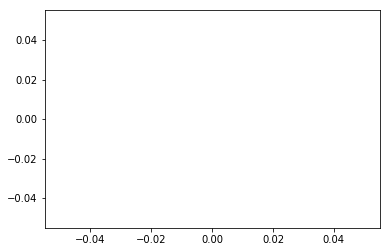

In [19]:
scatter(spikes[1], np.ones_like(spikes[1]));

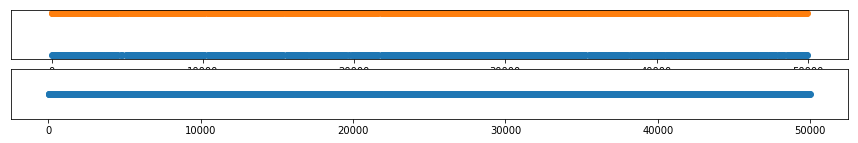

In [20]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

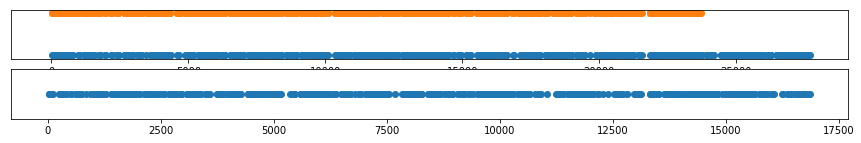

In [21]:
d=500


fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

In [22]:
device.reinit()
device.activate()

In [23]:
fits = fitter.generate(params=None, output_var='v',)

exponential_euler


In [24]:
t0 = np.arange(0, len(voltage1)*dt, dt)
t_ = spikes[0]
t = spikes[0][t_<3000]

In [25]:
t

array([   9.59,   11.29,   84.91,   90.38,  154.34,  176.97,  205.38,
        265.41,  290.49,  368.71,  411.3 ,  499.21,  506.29,  520.78,
        581.22,  590.44,  624.87,  687.32,  784.92,  853.72,  967.15,
        973.85, 1029.99, 1178.69, 1181.62, 1199.35, 1276.93, 1313.59,
       1317.39, 1375.45, 1419.61, 1422.28, 1464.11, 1513.32, 1516.41,
       1597.49, 1599.94, 1716.38, 1743.14, 1814.51, 1941.95, 1958.41,
       1984.83, 2124.03, 2175.94, 2179.79, 2197.33, 2217.02, 2344.7 ,
       2417.22, 2421.34, 2426.57, 2434.25, 2648.12, 2684.41, 2686.64,
       2790.43, 2810.72, 2818.63, 2858.49, 2867.24, 2889.93, 2924.62,
       2982.27, 2988.05])

In [26]:
os = array(out_spikes[0])
os[os<3000]

array([  10.85,   86.77,  152.87,  177.99,  206.49,  255.46,  289.97,
        351.57,  372.45,  411.88,  501.64,  514.26,  569.2 ,  588.26,
        617.37,  659.91,  705.57,  796.7 ,  968.93, 1029.32, 1179.85,
       1201.26, 1277.75, 1314.76, 1374.47, 1408.51, 1422.03, 1462.08,
       1485.98, 1514.33, 1597.82, 1717.75, 1744.83, 1814.92, 1943.69,
       1985.12, 2178.47, 2198.5 , 2217.57, 2345.9 , 2418.41, 2427.14,
       2450.77, 2650.41, 2686.33, 2729.71, 2792.29, 2818.29, 2859.09,
       2884.83, 2922.46, 2975.51, 2988.59])

In [27]:
v = fits[0]
d = 300000

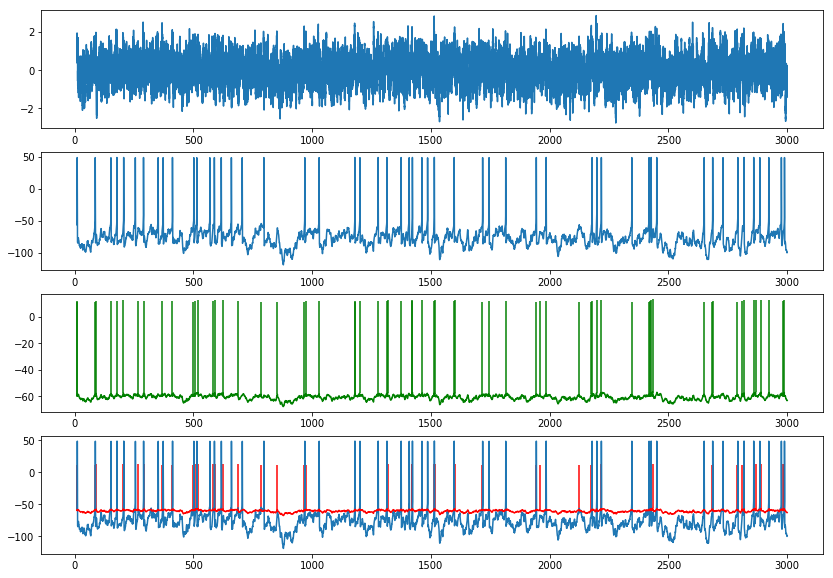

In [28]:
fig, ax = plt.subplots(nrows=4, figsize=(14,10))
ax[0].plot(t0[1000:d]/ms, inp_cur1[1000:d]);
ax[1].plot(t0[1000:d]/ms, voltage1[1000:d]);
ax[2].plot(t0[1000:d]/ms, v[1000:d]-60, 'g')
ax[2].vlines(t, v[np.int_(np.round(t/dt*ms))]+10, v[np.int_(np.round(t/dt*ms))]-60, 'g');

ax[3].plot(t0[1000:d]/ms, voltage1[1000:d]);
ax[3].plot(t0[1000:d]/ms, v[1000:d]-60, 'r')
ax[3].vlines(t, v[np.int_(np.round(t/dt*ms))]+10, v[np.int_(np.round(t/dt*ms))]-60, 'r');



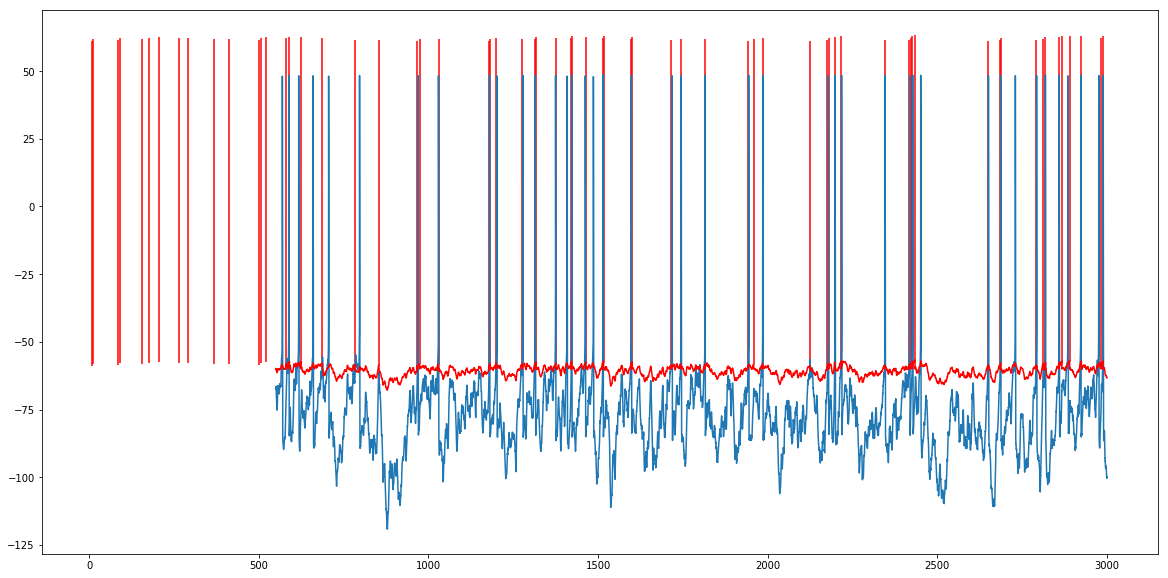

In [29]:
plt.figure(figsize=(20,10))
plot(t0[55000:d]/ms, voltage1[55000:d]);
plot(t0[55000:d]/ms, v[55000:d]-60, 'r')
vlines(t, v[np.int_(np.round(t/dt*ms))]+60, v[np.int_(np.round(t/dt*ms))]-60, 'r');
